<a href="https://colab.research.google.com/github/TrevBot17/NBA_Predict/blob/main/Predict_NBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [4]:
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time

In [5]:
team_dict = {'Atlanta Hawks' : 'ATL',
             'Boston Celtics' : 'BOS',
             'Brooklyn Nets' : 'BRK',
             'Charlotte Hornets' : 'CHO',
             'Chicago Bulls' : 'CHI',
             'Cleveland Cavaliers' : 'CLE',
             'Dallas Mavericks' : 'DAL',
             'Denver Nuggets' : 'DEN',
             'Detroit Pistons' : 'DET',
             'Golden State Warriors' : 'GSW',
             'Houston Rockets' : 'HOU',
             'Indiana Pacers' : 'IND',
             'Los Angeles Clippers' : 'LAC',
             'Los Angeles Lakers' : 'LAL',
             'Memphis Grizzlies' : 'MEM',
             'Miami Heat' : 'MIA',
             'Milwaukee Bucks' : 'MIL',
             'Minnesota Timberwolves' : 'MIN',
             'New Orleans Pelicans' : 'NOP',
             'New York Knicks' : 'NYK',
             'Oklahoma City Thunder' : 'OKC',
             'Orlando Magic' : 'ORL',
             'Philadelphia 76ers' : 'PHI',
             'Phoenix Suns' : 'PHO',
             'Portland Trail Blazers' : 'POR',
             'Sacramento Kings' : 'SAC',
             'San Antonio Spurs' : 'SAS',
             'Toronto Raptors' : 'TOR',
             'Utah Jazz' : 'UTA',
             'Washington Wizards' : 'WAS'}

## Defensive Ranks

In [6]:
def defensive_rank(season):
  # Opponent Defensive Rank
  def_url = 'https://www.basketball-reference.com/leagues/NBA_{}_ratings.html'.format(str(season))
  def_data = pd.read_html(def_url, skiprows = 1, header = 0)[0]
  return def_data[['Team', 'DRtg/A']]

## Random Forest Full Model

The full model uses the below variables to predict how many points each team scores in tonight's games.

-Average Points Per Game (PPG) season to date<br>
-Average PPG last 3 games<br>
-Home/Away<br>
-Days Rest<br>
-Opponents' adjusted defensive rating

In [7]:
# Make it all a function
def evaluate_preds(season, team, def_ranks):
  # Season: int (ex: 2022)
  # Team: str (ex: 'BOS')
  # Def_Ranks: dataframe created above. limit calls to bball-ref

  url = 'https://www.basketball-reference.com/teams/{}/{}_games.html'.format(team, str(season))
  data = pd.read_html(url)[0]
  data = data.rename(columns = {'Unnamed: 5' : 'Home',
                              'Unnamed: 7' : 'Result',
                              'Unnamed: 8' : 'Overtime',
                              'Tm' : 'Points_For',
                              'Opp' : 'Points_Against'})

  # Filter out extra rows in table
  data = data.loc[data['G'] != 'G']

  # Convert Date to datetime objects
  data['Date'] = pd.to_datetime(data['Date'])

  # Filter out games that haven't been played yet
  today = (datetime.today() - timedelta(hours = 8)).strftime('%Y-%m-%d')
  data = data[data['Date'] <= today]

  # Convert Points_For to int
  data['Points_For'] = data['Points_For'].astype('int', errors = 'ignore')

  # Clean Home/Away column
  data['Home'] = data['Home'].replace('@', 0)
  data['Home'] = data['Home'].fillna(1)
  data['Home'] = data['Home'].astype('int')

  # Add Days Rest column
  data['Days_Rest'] = data.Date.diff() - timedelta(days = 1)
  data['Days_Rest'] = data['Days_Rest'].fillna(data['Days_Rest'].median())
  data['Days_Rest'] = pd.to_numeric(data.Days_Rest.dt.days, downcast = 'integer')

  # Join data and def_data to add DRtg/A (adjusted defensive rating)
  data = data.merge(def_ranks, left_on = 'Opponent', right_on = 'Team').sort_values(by = ['Date'])

  # Set index to Date
  data = data.set_index('Date')

  # Avg points per game for the season
  data['Avg_Pts'] = data['Points_For'].rolling(window = 82, min_periods = 1).mean().shift(periods = 1)
  # data['Avg_Pts'].fillna(data['Avg_Pts'].mean()) not sure if a good idea to impute

  # Avg points per game last three games
  data['Avg_Pts_Last_3'] = data['Points_For'].rolling(window = 3, min_periods = 1).mean().shift(periods = 1)

  # Only numerical columns for regression
  # data variable has everything, plus NA values. df only has numerical values for regression
  df = data[['Points_For', 'Avg_Pts', 'Avg_Pts_Last_3', 'Home', 'Days_Rest', 'DRtg/A']].dropna()

  # Train Test Split
  X = df[['Avg_Pts', 'Avg_Pts_Last_3', 'Home', 'Days_Rest', 'DRtg/A']]
  y = df['Points_For']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)

  # RF consistently performs best. Not sure of real life applications of model choice
  # Take average of 10 RF regressors
  # Initially thought I would minimize the error but there's less variation in the RF regressors than hypothesized
  randoms = range(17, 27)
  errors = []
  for state in randoms:
    rf = RandomForestRegressor(n_estimators = 500, max_depth = 2, random_state = state).fit(X_train, y_train)
    y_preds = rf.predict(X_test)
    errors.append(mean_absolute_error(y_preds, y_test))
  
  return errors

In [8]:
# 2022 is the 2021-2022 NBA season on basketball-reference, the last full season
# 2023 is the current 2022-2023 NBA season
season = 2022
def_ranks = defensive_rank(season)

# Initialize dictionary to store errors
err_dict_full_model = {}

# Takes a couple mintues to run
for team in team_dict.values():
  err = evaluate_preds(season, team, def_ranks)
  err_dict_full_model[team] = err

err_df_full_model = pd.DataFrame(err_dict_full_model).transpose()
err_df_full_model['Mean Error'] = err_df_full_model.mean(axis = 1)
err_df_full_model

,0,1,2,3,4,5,6,7,8,9,Mean Error
ATL,10.914876,10.920555,10.996316,10.957654,10.846691,10.787910,11.042591,11.047394,10.945096,10.881035,10.934012
BOS,13.875018,13.968660,14.009179,13.844616,13.914751,13.763050,13.738967,13.915953,13.961058,13.988812,13.898006
BRK,9.733091,9.675847,9.579005,9.726916,9.621242,9.521564,9.673467,9.694871,9.696005,9.698884,9.662089
CHO,10.316505,10.299569,10.124493,10.269793,10.335884,10.195110,10.459605,10.404766,10.445815,10.471035,10.332258
CHI,12.338429,12.364013,12.456271,12.375261,12.409448,12.297314,12.334438,12.347019,12.423419,12.423811,12.376942
CLE,8.243027,8.214622,8.307213,8.326184,8.243825,8.243090,8.341810,8.300515,8.303360,8.328171,8.285182
DAL,10.217432,10.148556,10.029617,10.153660,10.143928,10.087865,10.269590,10.129967,10.028083,10.169722,10.137842
DEN,10.163290,10.130600,9.929194,10.121254,10.102291,10.046047,10.051317,10.086878,10.084982,9.964490,10.068034
DET,8.642686,8.563350,8.581512,8.738457,8.649248,8.557483,8.670896,8.621790,8.726482,8.573410,8.632532
GSW,10.072685,9.987530,10.026357,10.090428,10.102294,10.066492,10.098669,10.209796,10.035717,10.125832,10.081580


We're able to predict the accuracy of tonight's score within 7-10 points for most teams, which is a good starting point. The average number of points scored by an NBA team on a given night is 113-114 so our errors are in the 6-9% range

## Season Avg Pts

Is the full model above better at predicting the final score than just using each team's average scoring output season to date? Let's find out.

In [9]:
# Is it any better than taking the team's season average number of points?
def season_avg_pts(season, team):
  # Season: int (ex: 2022)
  # Team: str (ex: 'BOS')
  # Def_Ranks: dataframe created above. limit calls to bball-ref

  url = 'https://www.basketball-reference.com/teams/{}/{}_games.html'.format(team, str(season))
  data = pd.read_html(url)[0]
  data = data.rename(columns = {'Unnamed: 5' : 'Home',
                              'Unnamed: 7' : 'Result',
                              'Unnamed: 8' : 'Overtime',
                              'Tm' : 'Points_For',
                              'Opp' : 'Points_Against'})

  # Filter out extra rows in table
  data = data.loc[data['G'] != 'G']

  # Convert Date to datetime objects
  data['Date'] = pd.to_datetime(data['Date'])

  # Filter out games that haven't been played yet
  today = (datetime.today() - timedelta(hours = 8)).strftime('%Y-%m-%d')
  data = data[data['Date'] <= today]

  # Convert Points_For to int
  data['Points_For'] = data['Points_For'].astype('int', errors = 'ignore')

  # Clean Home/Away column
  data['Home'] = data['Home'].replace('@', 0)
  data['Home'] = data['Home'].fillna(1)
  data['Home'] = data['Home'].astype('int')

  # Add Days Rest column
  data['Days_Rest'] = data.Date.diff() - timedelta(days = 1)
  data['Days_Rest'] = data['Days_Rest'].fillna(data['Days_Rest'].median())
  data['Days_Rest'] = pd.to_numeric(data.Days_Rest.dt.days, downcast = 'integer')

  # Set index to Date
  data = data.set_index('Date')

  # Avg points per game for the season
  data['Avg_Pts'] = data['Points_For'].rolling(window = 82, min_periods = 1).mean().shift(periods = 1)
  # data['Avg_Pts'].fillna(data['Avg_Pts'].mean()) not sure if a good idea to impute

  # Only numerical columns for regression
  # data variable has everything, plus NA values. df only has numerical values for regression
  df = data[['Points_For', 'Avg_Pts', 'Home', 'Days_Rest']].dropna()

  # Train Test Split
  X = df[['Avg_Pts', 'Home', 'Days_Rest']]
  y = df['Points_For']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)

  # RF consistently performs best. Not sure of real life applications of model choice
  # Take average of 10 RF regressors
  # Initially thought I would minimize the error but there's less variation in the RF regressors than hypothesized
  randoms = range(17, 27)
  errors = []
  for state in randoms:
    rf = RandomForestRegressor(n_estimators = 500, max_depth = 2, random_state = state).fit(X_train, y_train)
    y_preds = rf.predict(X_test)
    errors.append(mean_absolute_error(y_preds, y_test))
  
  return errors

In [10]:
season = 2022

# Initialize dictionary to store errors
err_dict_simple = {}

# Takes a couple mintues to run
for team in team_dict.values():
  err = season_avg_pts(season, team)
  err_dict_simple[team] = err

err_df_simple = pd.DataFrame(err_dict_simple).transpose()
err_df_simple['Mean Error'] = err_df_simple.mean(axis = 1)
err_df_simple

,0,1,2,3,4,5,6,7,8,9,Mean Error
ATL,11.487161,11.382718,11.473197,11.501289,11.378804,11.462847,11.390847,11.502715,11.392698,11.435662,11.440794
BOS,14.164328,14.095020,14.150237,14.149357,14.122182,14.124894,14.147018,14.070932,14.274491,14.157885,14.145634
BRK,9.256827,9.322561,9.217926,9.324130,9.327288,9.270329,9.343654,9.264932,9.276741,9.316478,9.292087
CHO,12.272938,12.210352,12.251234,12.236629,12.167548,12.284442,12.224027,12.238569,12.089449,12.148082,12.212327
CHI,11.941616,11.950827,11.955036,12.034040,12.011039,11.995940,11.977788,12.077910,11.984457,11.935930,11.986458
CLE,8.765881,8.748233,8.885336,8.692396,8.831366,8.734577,8.693499,8.767217,8.799277,8.745629,8.766341
DAL,11.390562,11.424949,11.442508,11.462531,11.420011,11.493934,11.448864,11.501536,11.279096,11.462812,11.432680
DEN,10.099377,10.020964,9.825812,10.153176,9.836706,10.005059,10.055205,9.979834,9.994818,9.888486,9.985944
DET,9.008230,8.962335,8.919494,8.957327,8.932729,8.901524,8.988299,8.954290,9.002254,8.999470,8.962595
GSW,8.973419,9.004332,8.997084,8.879094,8.968207,9.072875,8.956069,9.048803,8.888176,8.982442,8.977050


In [11]:
np.sum(err_df_full_model['Mean Error'] - err_df_simple['Mean Error'])

-6.9361337751872565

The model that only uses Average Points as an explanatory variable is substantially worse than either model above (not shown). This simplified model that includes Average Points, Days Rest, and Home/Away is generally within 1 point of the full model above, but for most teams the full model is more accurate. The negative value above shows that errors are larger for the simple model.

When adding additional potential variables like Net Rating or Opponents Defensive Rating Last 3 Games, perform a similar evaluation to ensure the model is actually improving.

## Get Data And Predict

I've been using the full model to try to predict which team will cover the spread or if the over or under will hit. I benchmarked the data from 12/27/22 - 1/28/23 and the model accurately predicts which team will cover the spread 55% of the time, and accurately predicts the over/under 48% of the time. These results are not strong enough to do well against Vegas.

In [12]:
# Make it all a function
def predict_points(season, team, def_ranks):
  # Season: int (ex: 2022)
  # Team: str (ex: 'BOS')
  # Def_Ranks: dataframe created above. limit calls to bball-ref

  url = 'https://www.basketball-reference.com/teams/{}/{}_games.html'.format(team, str(season))
  data = pd.read_html(url)[0]
  data = data.rename(columns = {'Unnamed: 5' : 'Home',
                              'Unnamed: 7' : 'Result',
                              'Unnamed: 8' : 'Overtime',
                              'Tm' : 'Points_For',
                              'Opp' : 'Points_Against'})

  # Filter out extra rows in table
  data = data.loc[data['G'] != 'G']

  # Convert Date to datetime objects
  data['Date'] = pd.to_datetime(data['Date'])

  # Filter out games that haven't been played yet
  today = (datetime.today() - timedelta(hours = 8)).strftime('%Y-%m-%d')
  data = data[data['Date'] <= today]

  # Convert Points_For to int
  data['Points_For'] = data['Points_For'].astype('int', errors = 'ignore')

  # Clean Home/Away column
  data['Home'] = data['Home'].replace('@', 0)
  data['Home'] = data['Home'].fillna(1)
  data['Home'] = data['Home'].astype('int')

  # Add Days Rest column
  data['Days_Rest'] = data.Date.diff() - timedelta(days = 1)
  data['Days_Rest'] = data['Days_Rest'].fillna(data['Days_Rest'].median())
  data['Days_Rest'] = pd.to_numeric(data.Days_Rest.dt.days, downcast = 'integer')

  # Join data and def_data to add DRtg/A (adjusted defensive rating)
  data = data.merge(def_ranks, left_on = 'Opponent', right_on = 'Team').sort_values(by = ['Date'])

  # Set index to Date
  data = data.set_index('Date')

  # Avg points per game for the season
  data['Avg_Pts'] = data['Points_For'].rolling(window = 82, min_periods = 1).mean().shift(periods = 1)
  # data['Avg_Pts'].fillna(data['Avg_Pts'].mean()) not sure if a good idea to impute

  # Avg points per game last three games
  data['Avg_Pts_Last_3'] = data['Points_For'].rolling(window = 3, min_periods = 1).mean().shift(periods = 1)

  # Only numerical columns for regression
  # data variable has everything, plus NA values. df only has numerical values for regression
  df = data[['Points_For', 'Avg_Pts', 'Avg_Pts_Last_3', 'Home', 'Days_Rest', 'DRtg/A']].dropna()

  # Train Test Split
  X = df[['Avg_Pts', 'Avg_Pts_Last_3', 'Home', 'Days_Rest', 'DRtg/A']]
  y = df['Points_For']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)

  # RF consistently performs best. Not sure of real life applications of model choice
  rf = RandomForestRegressor(n_estimators = 500, max_depth = 2, random_state = 17).fit(X_train, y_train)

  # Calculate the five inputs and pass to the predict function
  avg_pts = data[data.index == today]['Avg_Pts'][0]
  avg_pts_3 = data[data.index == today]['Avg_Pts_Last_3'][0]
  home = data[data.index == today]['Home'][0]
  days_rest = data[data.index == today]['Days_Rest'][0]
  def_rating = data[data.index == today]['DRtg/A'][0]

  inputs = pd.DataFrame([[avg_pts, avg_pts_3, home, days_rest, def_rating]], columns = list(X_train.columns))
  return rf.predict(inputs)

## Visualization

A plot of the predicted points vs. actual points for the Golden State Warriors during the 2021-2022 season

In [16]:
# Make it all a function
def return_model(season, team, def_ranks):
  # Season: int (ex: 2022)
  # Team: str (ex: 'BOS')
  # Def_Ranks: dataframe created above. limit calls to bball-ref

  url = 'https://www.basketball-reference.com/teams/{}/{}_games.html'.format(team, str(season))
  data = pd.read_html(url)[0]
  data = data.rename(columns = {'Unnamed: 5' : 'Home',
                              'Unnamed: 7' : 'Result',
                              'Unnamed: 8' : 'Overtime',
                              'Tm' : 'Points_For',
                              'Opp' : 'Points_Against'})

  # Filter out extra rows in table
  data = data.loc[data['G'] != 'G']

  # Convert Date to datetime objects
  data['Date'] = pd.to_datetime(data['Date'])

  # Filter out games that haven't been played yet
  today = (datetime.today() - timedelta(hours = 8)).strftime('%Y-%m-%d')
  data = data[data['Date'] <= today]

  # Convert Points_For to int
  data['Points_For'] = data['Points_For'].astype('int', errors = 'ignore')

  # Clean Home/Away column
  data['Home'] = data['Home'].replace('@', 0)
  data['Home'] = data['Home'].fillna(1)
  data['Home'] = data['Home'].astype('int')

  # Add Days Rest column
  data['Days_Rest'] = data.Date.diff() - timedelta(days = 1)
  data['Days_Rest'] = data['Days_Rest'].fillna(data['Days_Rest'].median())
  data['Days_Rest'] = pd.to_numeric(data.Days_Rest.dt.days, downcast = 'integer')

  # Join data and def_data to add DRtg/A (adjusted defensive rating)
  data = data.merge(def_ranks, left_on = 'Opponent', right_on = 'Team').sort_values(by = ['Date'])

  # Set index to Date
  data = data.set_index('Date')

  # Avg points per game for the season
  data['Avg_Pts'] = data['Points_For'].rolling(window = 82, min_periods = 1).mean().shift(periods = 1)
  # data['Avg_Pts'].fillna(data['Avg_Pts'].mean()) not sure if a good idea to impute

  # Avg points per game last three games
  data['Avg_Pts_Last_3'] = data['Points_For'].rolling(window = 3, min_periods = 1).mean().shift(periods = 1)

  # Only numerical columns for regression
  # data variable has everything, plus NA values. df only has numerical values for regression
  df = data[['Points_For', 'Avg_Pts', 'Avg_Pts_Last_3', 'Home', 'Days_Rest', 'DRtg/A']].dropna()

  # Train Test Split
  X = df[['Avg_Pts', 'Avg_Pts_Last_3', 'Home', 'Days_Rest', 'DRtg/A']]
  y = df['Points_For']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)

  # RF consistently performs best. Not sure of real life applications of model choice
  rf = RandomForestRegressor(n_estimators = 500, max_depth = 2, random_state = 17).fit(X_train, y_train)
  return df, rf

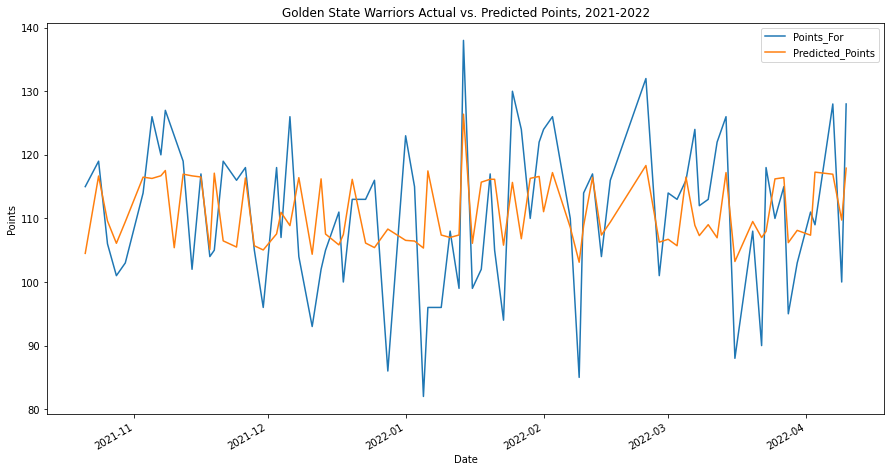

In [38]:
season, team = 2022, 'GSW'
def_ranks = defensive_rank(season)
viz_df, mod = return_model(season, team, def_ranks)

# Inputs for model .predict
X = viz_df[viz_df.columns[1:]]
y_pred = mod.predict(X)

# Add to viz_df
viz_df['Predicted_Points'] = y_pred

# And plot
viz_df[['Points_For', 'Predicted_Points']].plot(
    figsize = (15, 8),
    title = 'Golden State Warriors Actual vs. Predicted Points, 2021-2022',
    ylabel = 'Points'
);

## Today's Games

In [13]:
# Make it all a function
def todays_games():
  currentMonth = (datetime.now() - timedelta(hours = 8)).strftime('%B')
  schedule = 'https://www.basketball-reference.com/leagues/NBA_2023_games-{}.html'.format(currentMonth.lower())

  sch = pd.read_html(schedule)[0]
  sch = sch.rename(columns = {'Visitor/Neutral' : 'Away',
                              'Home/Neutral' : 'Home'})

  # Convert Date to datetime objects
  sch['Date'] = pd.to_datetime(sch['Date'])

  # Filter df to today's date
  today = (datetime.today() - timedelta(hours = 8)).strftime('%Y-%m-%d')
  sch = sch[sch['Date'] == today]

  return sch[['Date', 'Away', 'Home']]

sch = todays_games()
games = list(zip(sch['Away'], sch['Home']))

In [14]:
print((datetime.today() - timedelta(hours = 8)).strftime('%Y-%m-%d'))
season = 2023
def_ranks = defensive_rank(season)
i = 1
for a, h in games:
  away = team_dict[a]
  home = team_dict[h]
  time.sleep(2)
  away_pts = np.round(predict_points(season, away, def_ranks), 2)
  time.sleep(2)
  home_pts = np.round(predict_points(season, home, def_ranks), 2)
  print('Game {}'.format(i))
  print('{}: {}'.format(away, away_pts))
  print('{}: {}'.format(home, home_pts))
  print()
  i += 1

2023-02-05
Game 1
ORL: [112.11]
CHO: [110.89]

Game 2
CLE: [111.19]
IND: [117.99]

Game 3
TOR: [110.53]
MEM: [119.64]

Game 4
PHI: [118.86]
NYK: [107.37]

Game 5
DEN: [106.2]
MIN: [116.73]

Game 6
SAC: [113.32]
NOP: [119.54]

